# Hypergraph-to-Simplicial Weighted Simplicial Lifting Tutorial

***
This notebook shows how to import a dataset, with the desired lifting, and how to run a neural network using the loaded data.

The notebook is divided into sections:

- [Loading the dataset](#loading-the-dataset) loads the config files for the data and the desired tranformation, createsa a dataset object and visualizes it.
- [Loading and applying the lifting](#loading-and-applying-the-lifting) defines a simple neural network to test that the lifting creates the expected incidence matrices.
- [Create and run a simplicial nn model](#create-and-run-a-simplicial-nn-model) simply runs a forward pass of the model to check that everything is working as expected.

***
***

Note that for simplicity the notebook is setup to use a simple graph. However, there is a set of available datasets that you can play with.

To switch to one of the available datasets, simply change the *dataset_name* variable in [Dataset config](#dataset-config) to one of the following names:

* cocitation_cora
* cocitation_citeseer
* cocitation_pubmed
* MUTAG
* NCI1
* NCI109
* PROTEINS_TU
* AQSOL
* ZINC
***

### Imports and utilities

In [5]:
# With this cell any imported module is reloaded before each cell execution
%load_ext autoreload
%autoreload 2
from modules.data.load.loaders import GraphLoader
from modules.data.preprocess.preprocessor import PreProcessor
from modules.utils.utils import (
    describe_data,
    load_dataset_config,
    load_model_config,
    load_transform_config,
)

## Loading the Dataset

Here we just need to spicify the name of the available dataset that we want to load. First, the dataset config is read from the corresponding yaml file (located at `/configs/datasets/` directory), and then the data is loaded via the implemented `Loaders`.


In [6]:
# TODO - add citation/collaboration network dataset

dataset_name = "manual_dataset"
dataset_config = load_dataset_config(dataset_name)
loader = GraphLoader(dataset_config)
graph_dataset = loader.load()

# Since the base dataset is a graph, we need to lift it to a hypergraph
transform_type = "liftings"
transform_id = "graph2hypergraph/knn_lifting"
transform_config = {"lifting": load_transform_config(transform_type, transform_id)}

dataset = PreProcessor(graph_dataset, transform_config, loader.data_dir)


Dataset configuration for manual_dataset:

{'data_domain': 'graph',
 'data_type': 'toy_dataset',
 'data_name': 'manual',
 'data_dir': 'datasets/graph/toy_dataset',
 'num_features': 1,
 'num_classes': 2,
 'task': 'classification',
 'loss_type': 'cross_entropy',
 'monitor_metric': 'accuracy',
 'task_level': 'node'}

Transform configuration for graph2hypergraph/knn_lifting:

{'transform_type': 'lifting',
 'transform_name': 'HypergraphKNNLifting',
 'k_value': 3,
 'loop': True,
 'feature_lifting': 'ProjectionSum'}
Transform parameters are the same, using existing data_dir: /Users/tlong/Documents/code/challenge-icml-2024/datasets/graph/toy_dataset/manual/lifting/557134810



Dataset only contains 1 sample:


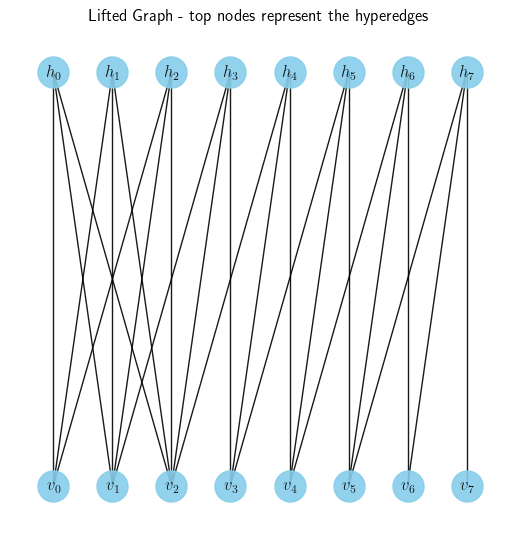

 - Hypergraph with 8 vertices and 8 hyperedges.
 - The nodes have feature dimensions 1.
 - The hyperedges have feature dimensions 1.



In [7]:
describe_data(dataset)

## Loading and Applying the Lifting

In this section we will instantiate the lifting we want to apply to the data. For this example the weighted simplicial complex lifting from the paper [[1]](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.106.034319) was chosen.
***
[[1]](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.106.034319) Baccini, Federica, Filippo Geraci, and Ginestra Bianconi. "Weighted simplicial complexes and their representation power of higher-order network data and topology." Physical Review E 106.3 (2022): 034319.
***

In [8]:
# Define transformation type and id
transform_type = "liftings"
# If the transform is a topological lifting, it should include both the type of the lifting and the identifier
transform_id = "hypergraph2simplicial/weighted_simplicial_lifting"

# Read yaml file
transform_config = {
    "lifting": load_transform_config(transform_type, transform_id)
    # other transforms (e.g. data manipulations, feature liftings) can be added here
}


Transform configuration for hypergraph2simplicial/weighted_simplicial_lifting:

{'transform_type': 'lifting',
 'transform_name': 'WeightedSimplicialLifting',
 'feature_lifting': 'ProjectionSum'}


We than apply the transform via our `PreProcesor`:

In [188]:
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir)
describe_data(lifted_dataset)

Processing...


TypeError: torch_geometric.data.data.Data() got multiple values for keyword argument 'x_0'

## Create and Run a Simplicial NN Model

In this section a simple model is created to test that the used lifting works as intended. In this case the model uses the `up_laplacian_1` and the `down_laplacian_1` so the lifting should make sure to add them to the data.

In [12]:
from modules.models.simplicial.san import SANModel

model_type = "simplicial"
model_id = "san"
model_config = load_model_config(model_type, model_id)

model = SANModel(model_config, dataset_config)


Model configuration for simplicial SAN:

{'in_channels': None,
 'hidden_channels': 32,
 'out_channels': None,
 'n_layers': 2,
 'n_filters': 2,
 'order_harmonic': 5,
 'epsilon_harmonic': 0.1}


In [13]:
y_hat = model(lifted_dataset.get(0))

If everything is correct the cell above should execute without errors. 